Esercizi
1) Plottare tre gaussiane
2) Kalman Filter univariato
3) kalman Filter multivariato
4) Unscented Kalman Filter

1) Plottare tre gaussiane:
Importiamo le seguenti librerie

In [1]:
import numpy as np
import random
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import scipy.stats
import filterpy.stats as stats
from numpy.random import randn
from filterpy.stats import gaussian

Creiamo l'asse delle ascisse mediante un array che va da 15 a 29 e passo 0.05 nel seguente
modo

In [2]:
xs = np.arange(15, 30, 0.05)

Per plottare ad esempio una Gaussiana avente valore atteso (media) uguale a 23 e
varianza uguale a 0.2**2:

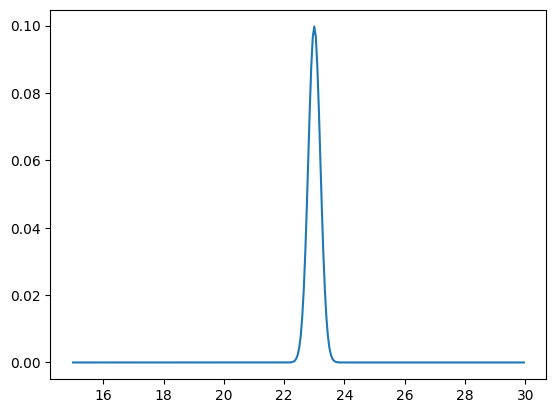

In [3]:
plt.plot(xs, gaussian(xs, 23, 0.2**2), label='$\sigma^2=0.2^2$')

Di seguito il codice completo:

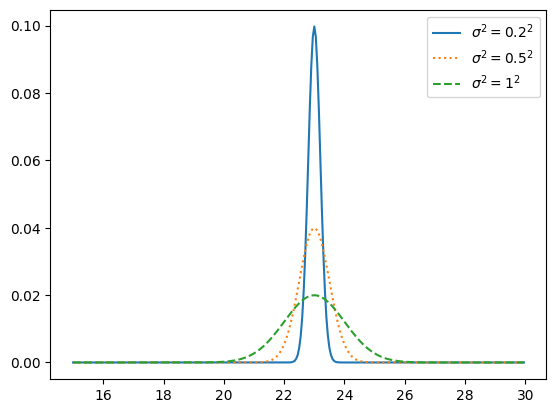

In [4]:
import numpy as np
import random
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import scipy.stats
import filterpy.stats as stats
from numpy.random import randn
from filterpy.stats import gaussian

xs = np.arange(15, 30, 0.05)

plt.plot(xs, gaussian(xs, 23, 0.2**2), label='$\sigma^2=0.2^2$')
plt.plot(xs, gaussian(xs, 23, .5**2), label='$\sigma^2=0.5^2$', ls=':')
plt.plot(xs, gaussian(xs, 23, 1**2), label='$\sigma^2=1^2$', ls='--')

plt.legend() #mostra la legenda
plt.show() #mostra il grafico

2) Kalman Filter univariato:
Importiamo le seguenti librerie:

In [ ]:
from asyncio import PriorityQueue
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation
import numpy as np
import filterpy.stats as stats
from collections import namedtuple
import matplotlib.pyplot as plt
from ipywidgets import interact
from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider

Definiamo una tupla e un numero random

In [ ]:
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian._repr_ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

np.random.seed(13)

Tenendo sempre a mente che la credenza iniziale bel(x0) è rappresentata da una gaussiana e una gaussiana è determinata da valore atteso (media) e varianza, definiamo le seguenti funzioni:
- predict, che dati in input posizione e movimento, dà in output la stima della credenza (belief);
- gaussian_multiply, che effettua la moltiplicazione di due gaussiane e ritorna la gaussiana risultante;
- update, che dati in input belief e misura (entrambe gaussiane), dà in output la belief aggiornata (che a sua volta sarà una gaussiana) .

In [ ]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)


def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

A questo punto, definiamo:
- Varianza del processo (azione) e quella del sensore; 
- x, posizione iniziale del cane, come una gaussiana a valore atteso nullo e varianza 20.*2. 
- Velocità=1 e spostamento dt=1
- Il movimento del cane, process_model, come una gaussiana avente media velocity*dt e varianza pari a quella del processo

In [ ]:
process_var = 2. # variance in the dog's movement
sensor_var = 4.5 # variance in the sensor

x = gaussian(0., 20.*2)  # dog's position, N(0, 20*2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x

Creiamo la simulazione del cane dando:
- Posizione iniziale x0 pari al valore atteso della gaussiana x (che rappresenta, appunto, la posizione iniziale) 
- Velocità pari al valore atteso della gaussiana del modello dell'azione
- Misura pari alla varianza del sensore (4.5)
- Varianza dell'azione pari alla varianza della gaussiana del modello dell'azione

A questo punto, creiamo una lista contenente 10 misurazioni e delle liste che conterranno l'output e che saranno utili ai fini del plottaggio. 

In [ ]:
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)] 

print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# save output in these lists for plotting
xs, predictions, v = [], [], [] 


PREDICT			UPDATE
     x      var		  z	    x      var


Adesso, eseguiamo il filtro di Kalman. 

Ad ogni misurazione:
- Calcoliamo predizione (fatta attraverso il modello dell'azione), la gaussiana risultante dalla relativa misurazione e l'aggiornamento che andrà a correggere la predizione.
- Utilizziamo le liste precedentemente create (xs, predictions, v) per memorizzare rispettivamente media della predizione corrente, valore atteso della belief aggiornata corrente e varianza della belief aggiornata corrente. 
- Stampiamo l'attuale predizione(prior), l'attuale belief aggiornata (x) e l'attuale misura corrente (z)

In [ ]:
# perform Kalman filter
for z in zs:    
    prior = predict(x, process_model)   #belief iniziale
    likelihood = gaussian(z, sensor_var)    #misura
    x = update(prior, likelihood)   #belief aggiornato

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)
    v.append(x.var)
    
    kf_internal.print_gh(prior, x, z) #stampa predizione, belief aggiornata e misura corrente
    

  1.000   42.000	1.592	  1.534   4.065
  2.534    6.065	1.888	  2.163   2.583
  3.163    4.583	4.961	  4.070   2.271
  5.070    4.271	8.568	  6.774   2.191
  7.774    4.191	7.615	  7.697   2.170
  8.697    4.170	7.040	  7.900   2.164
  8.900    4.164	10.996	  9.908   2.163
 10.908    4.163	14.478	 12.623   2.162
 13.623    4.162	19.547	 16.470   2.162
 17.470    4.162	16.786	 17.141   2.162


Stampiamo il valore atteso finale e la posizione finale del cane

In [ ]:
print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {dog.x:10.3f}')


final estimate:            17.141
actual final position:     16.842


Ai fini del plottaggio, definiamo la funzione plot_filter.
Per mostrare la fascia di varianze nel grafico, passiamo la lista v (lista precendentemente creata e in cui abbiamo memorizzato i valori delle varianze) come parametro alla funzione plot_filter().

In [ ]:
def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])  
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1], var=v[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1], var=v[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i], var=v[:i])
        print(xs)
    
    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2)
    plt.show()
    
interact(plot_filter, step=30)

interactive(children=(IntSlider(value=30, description='step', max=90, min=-30), Output()), _dom_classes=('widg…

<function __main__.plot_filter(step)>

Di seguito il codice completo:

In [ ]:
from asyncio import PriorityQueue
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation
import numpy as np
import filterpy.stats as stats
from collections import namedtuple
import matplotlib.pyplot as plt
from ipywidgets import interact



gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian._repr_ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

np.random.seed(13)


def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)


def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

process_var = 2. # variance in the dog's movement
sensor_var = 4.5 # variance in the sensor

x = gaussian(0., 20.*2)  # dog's position, N(0, 20*2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)] 

print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider

# save output in these lists for plotting
xs, predictions, v = [], [], []

# perform Kalman filter
for z in zs:    
    prior = predict(x, process_model)   #belief iniziale
    likelihood = gaussian(z, sensor_var)    #misura
    x = update(prior, likelihood)   #belief aggiornato

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)
    v.append(x.var)
    
    kf_internal.print_gh(prior, x, z)
    
print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {dog.x:10.3f}')



def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])  
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1], var=v[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1], var=v[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i], var=v[:i])
        print(xs)
    
    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2)
    plt.show()
 
interact(plot_filter, step=30)

3) Kalman Filter multivariato:
Importiamo le seguenti librerie:

In [ ]:
import math
import numpy as np
from numpy.random import randn
from asyncio import PriorityQueue
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation
import numpy as np
import filterpy.stats as stats
from collections import namedtuple
import matplotlib.pyplot as plt
from ipywidgets import interact
from filterpy.common import Q_discrete_white_noise
from kf_book.mkf_internal import plot_track
from filterpy.kalman import KalmanFilter
from filterpy.stats import plot_covariance_ellipse
from kf_book import book_plots as book_plots

Definiamo le seguenti funzioni: predict(), gaussian_multiply() e update() sono le funzioni utilizzate per la predizione e correzione.

Compute_dog_date() è la funzione che prende in input: 
- varianza del sensore
- varianza del processo
- count (numero di misurazioni)
- time step in secondi
e restituisce in output gli array xs e zs cioè le posizioni e le misurazioni effettuate. 

Pos_Vel_Filter() è la funzione che prende in input:
- posizione
- matrice di covarianza
- rumore della varianza
- stato
- time step in secondi 
e restitusce in output un kalman filter che implementa un modello di velocità costante per uno stato [x dx].T

Run() è una funzione che prende in input:
- posizione inziale
- matrice di covarianza 
- rumore della varianza
- stato
- time step in secondi
- attuale posizione del cane e corrispondenti misurazioni (track e zs) 
- altri parametri utili
Controlla se sono forniti dati. Se non sono forniti dati chiama la funzione compute_dog_date(). 
Crea il Kalman Filter chiamando la funzione pos_vel_filter()
Esegue il Kalman Filter, memorizza i risultati negli array xs e cov e li restituisce in output.
Successivamente fa il plottaggio.


In [ ]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)


def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """

    # Simulate dog if no data provided. 
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    
    plot_covariance_ellipse(xs[0], cov[0], edgecolor='r')
    
    for _ in range(5):
        plot_covariance_ellipse(xs[_],cov[_], edgecolor='r')
        book_plots.set_labels(x='position',y='velocity')    
     
    return xs, cov


come per il caso univariato, definiamo: 
- una tupla e un numero random;
- Varianza del processo (azione) e quella del sensore; 
- x, posizione iniziale del cane (gaussiana a valore atteso nullo e varianza 20.*2);
- Velocità=1 e spostamento dt=1;
- Il movimento del cane, process_model (gaussiana avente media velocity*dt e varianza pari a quella del processo);

Creiamo:
- la simulazione del movimento del cane e una lista di misurazioni di 10 elementi.
- 3 array per il salvataggio delle posizioni prima e dopo la correzione;
successivamente eseguiamo il filtro di Kalman, salviamo i risultati e li stampiamo.

In [ ]:
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian._repr_ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

np.random.seed(13)

process_var = 2. # variance in the dog's movement
sensor_var = 4.5 # variance in the sensor

x = gaussian(0., 20.*2)  # dog's position, N(0, 20*2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)] 

print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# save output in these lists for plotting
xs, predictions, v = [], [], []

for z in zs:    
    prior = predict(x, process_model)   #belief iniziale
    likelihood = gaussian(z, sensor_var)    #misura(osservazione)
    x = update(prior, likelihood)   #belief aggiornato

    # save results
    predictions.append(prior.mean)      #posizioni prima della correzione
    xs.append(x.mean)   #posizioni dopo la correzione
    v.append(x.var)     #varianze dopo la correzione
    
    kf_internal.print_gh(prior, x, z)
    
print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {dog.x:10.3f}')


PREDICT			UPDATE
     x      var		  z	    x      var
  1.000   42.000	1.592	  1.534   4.065
  2.534    6.065	1.888	  2.163   2.583
  3.163    4.583	4.961	  4.070   2.271
  5.070    4.271	8.568	  6.774   2.191
  7.774    4.191	7.615	  7.697   2.170
  8.697    4.170	7.040	  7.900   2.164
  8.900    4.164	10.996	  9.908   2.163
 10.908    4.163	14.478	 12.623   2.162
 13.623    4.162	19.547	 16.470   2.162
 17.470    4.162	16.786	 17.141   2.162

final estimate:            17.141
actual final position:     16.842


Definiamo la matrice di covarianza P tramite la funzione diag() ricordando che la diagonale di una matrice di covarianza contiene la varianza di ogni variabile di stato. 

Chiamiamo la funzione run(), precedentemente definita per eseguire il filtro di Kalman, passandogli tali parametri:
- count=50 (50 misurazioni)
- R=10 (rumore varianza)
- Q=0.01 (varianza del processo)
- P=P (matrice di covarianza precedentemente definita) 

Salviamo i due valori di xs e cov restituiti dal metodo run in 2 variabili: Ms e Ps. Infine facciamo il plottaggio.
xs è un array di x.

Nella funzione pos_vel_filer() precedentemente definita, x è un array bidimensionale che ha come indice i valori di x[0], x[1] dove x[0] indica la posizione e x[1] indica la velocità.

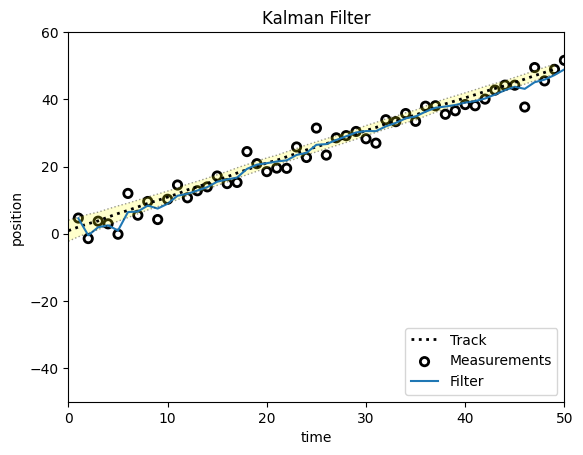

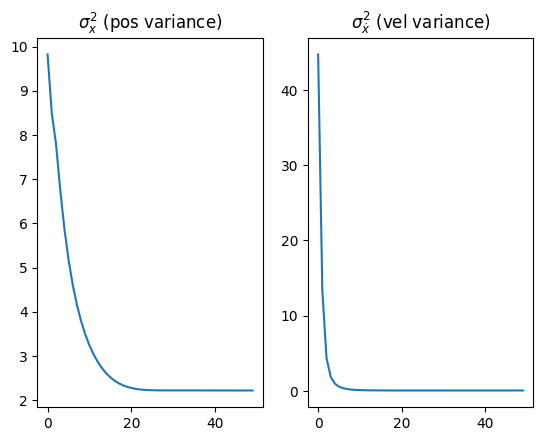

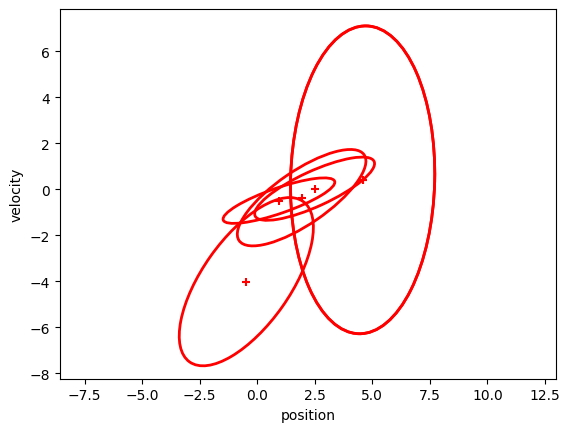

In [ ]:
P = np.diag([500., 49.])   #P=matrice di covarianza
Ms, Ps = run(count=50, R=10, Q=0.01, P=P) #rumore varianza=10 misurazioni=50 varianza processo=0.01
plt.show()

Plottiamo posizione e velocità in funzione del tempo (50 step)

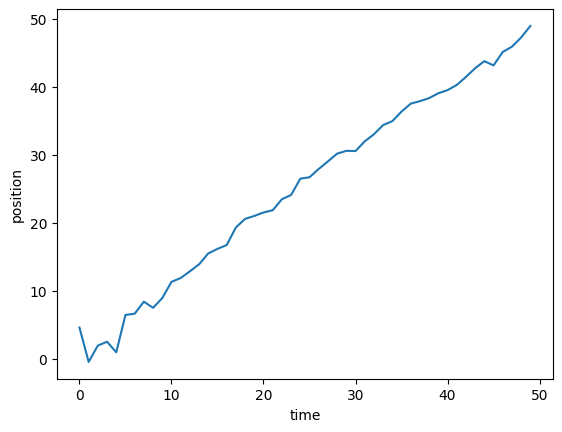

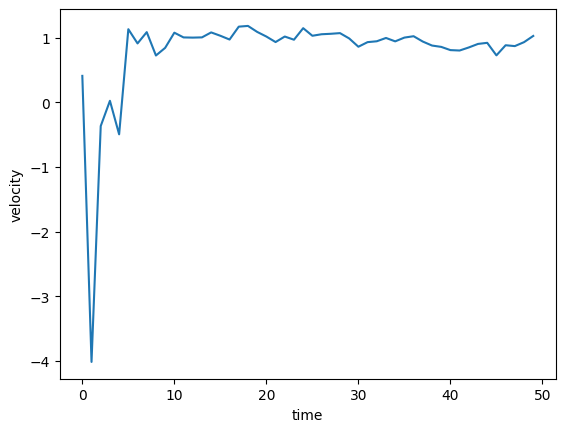

In [ ]:
plt.plot(Ms[:,0])  #Ms[x[x[0],x[1]]]     Ms[1:0,1] prima di : scegliamo l'indice dell'array x e dopo i : scegliamo gli indici 0 o 1 a seconda che vogliamo posizione o velocità
book_plots.set_labels(x='time', y='position')
plt.show()
plt.plot(Ms[:,1])
book_plots.set_labels(x='time', y='velocity')
plt.show()

Plottiamo il grafico delle ellissi, cioè la rappresentazione del filtro di Kalman multivariato. In particolare, partendo da uno stato F, mostriamo come varia la covarianza, proiettando lo stato in avanti di 6/10 di secondo per 5 volte.

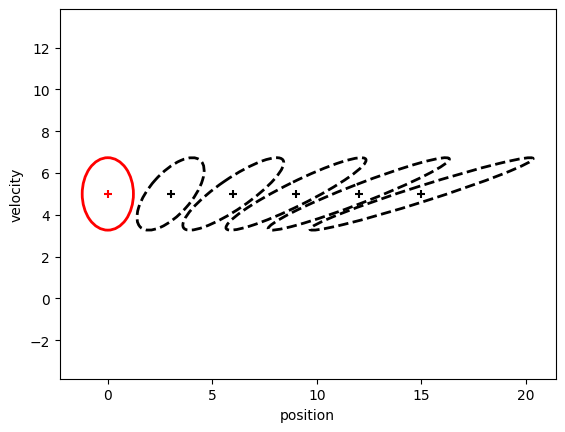

In [ ]:
dt = 0.6
x = np.array([0., 5.])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[1.5, 0], [0, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(5):
    x = F @ x
    P = F @ P @ F.T
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
book_plots.set_labels(x='position', y='velocity')

plt.show()

Mostriamo di seguito il codice completo

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000   42.000	1.592	  1.534   4.065
  2.534    6.065	1.888	  2.163   2.583
  3.163    4.583	4.961	  4.070   2.271
  5.070    4.271	8.568	  6.774   2.191
  7.774    4.191	7.615	  7.697   2.170
  8.697    4.170	7.040	  7.900   2.164
  8.900    4.164	10.996	  9.908   2.163
 10.908    4.163	14.478	 12.623   2.162
 13.623    4.162	19.547	 16.470   2.162
 17.470    4.162	16.786	 17.141   2.162

final estimate:            17.141
actual final position:     16.842


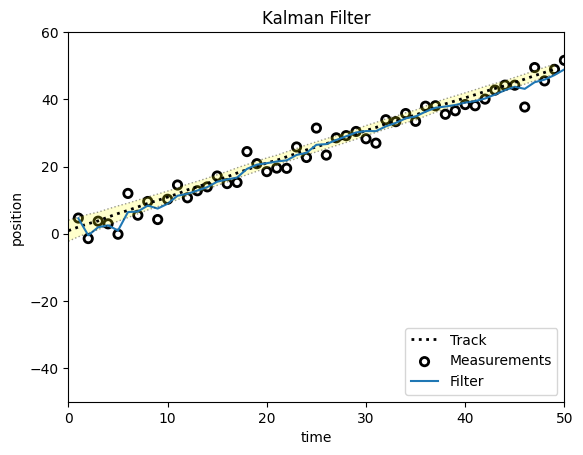

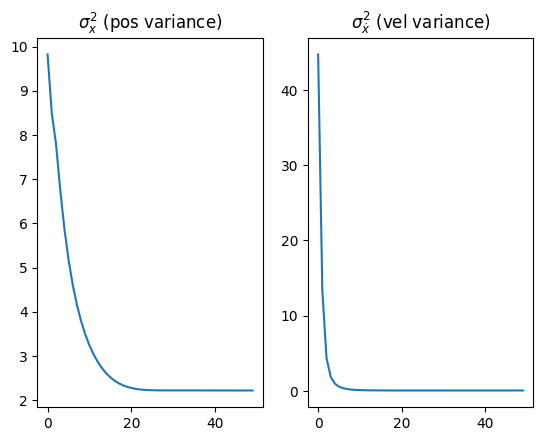

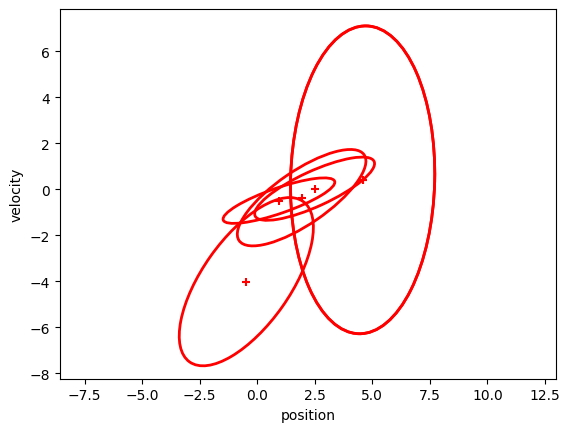

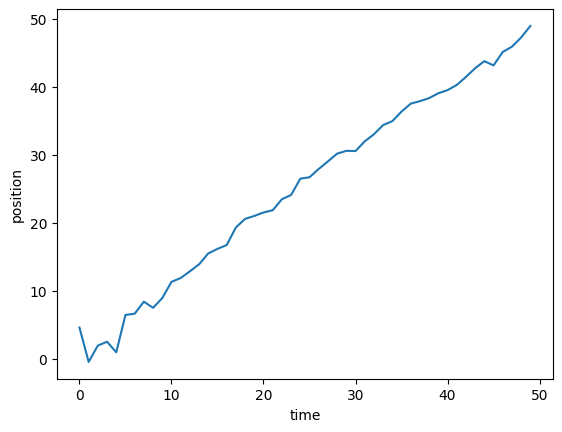

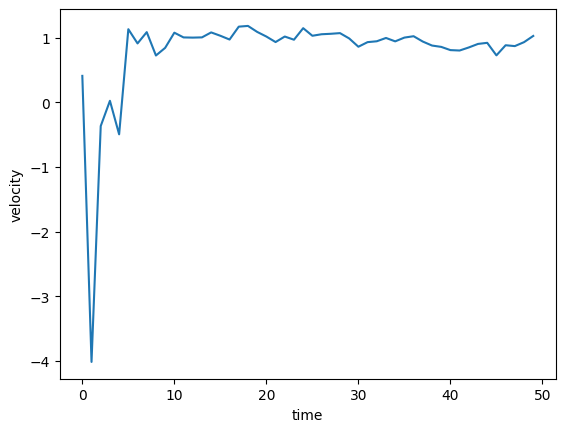

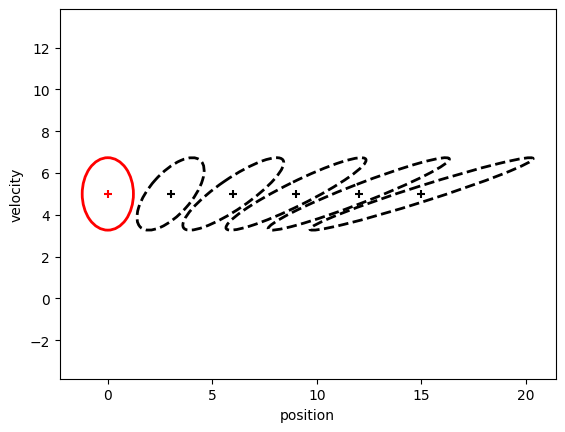

In [ ]:
import math
import numpy as np
from numpy.random import randn
from asyncio import PriorityQueue
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation
import numpy as np
import filterpy.stats as stats
from collections import namedtuple
import matplotlib.pyplot as plt
from ipywidgets import interact
from filterpy.common import Q_discrete_white_noise
from kf_book.mkf_internal import plot_track
from filterpy.kalman import KalmanFilter
from filterpy.stats import plot_covariance_ellipse
from kf_book import book_plots as book_plots

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)


def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """

    # Simulate dog if no data provided. 
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    
    plot_covariance_ellipse(xs[0], cov[0], edgecolor='r')
    
    for _ in range(5):
        plot_covariance_ellipse(xs[_],cov[_], edgecolor='r')
        book_plots.set_labels(x='position',y='velocity')    
     
    return xs, cov

gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian._repr_ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

np.random.seed(13)

process_var = 2. # variance in the dog's movement
sensor_var = 4.5 # variance in the sensor

x = gaussian(0., 20.*2)  # dog's position, N(0, 20*2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)] 

print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# save output in these lists for plotting
xs, predictions, v = [], [], []

for z in zs:    
    prior = predict(x, process_model)   #belief iniziale
    likelihood = gaussian(z, sensor_var)    #misura(osservazione)
    x = update(prior, likelihood)   #belief aggiornato

    # save results
    predictions.append(prior.mean)      #posizioni prima della correzione
    xs.append(x.mean)   #posizioni dopo la correzione
    v.append(x.var)     #varianze dopo la correzione
    
    kf_internal.print_gh(prior, x, z)
    
print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {dog.x:10.3f}')


#Ms è xs restituito da run e Ps è cov restituto da run
P = np.diag([500., 49.])   #P=matrice di covarianza. 
Ms, Ps = run(count=50, R=10, Q=0.01, P=P) #rumore varianza=10 misurazioni=50 varianza processo=0.01
plt.show()

plt.plot(Ms[:,0])  #Ms[x[x[0],x[1]]]     Ms[1:0,1] prima di : scegliamo l'indice dell'array x e dopo i : scegliamo gli indici 0 o 1 a seconda che vogliamo posizione o velocità
book_plots.set_labels(x='time', y='position')
plt.show()
plt.plot(Ms[:,1])
book_plots.set_labels(x='time', y='velocity')
plt.show()

dt = 0.6
x = np.array([0., 5.])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[1.5, 0], [0, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(5):
    x = F @ x
    P = F @ P @ F.T
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
book_plots.set_labels(x='position', y='velocity')

plt.show()

4. Unscented Kalman Filter
Inizialmente, si importano le seguenti librerie.

In [ ]:
from kf_book.book_plots import set_figsize, figsize
import matplotlib.pyplot as plt
from kf_book.nonlinear_plots import plot_nonlinear_func
from numpy.random import normal
import numpy as np
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats
from numpy.random import multivariate_normal
from kf_book.nonlinear_plots import plot_monte_carlo_mean


Si creano 500.000 campioni con media 0, std -1

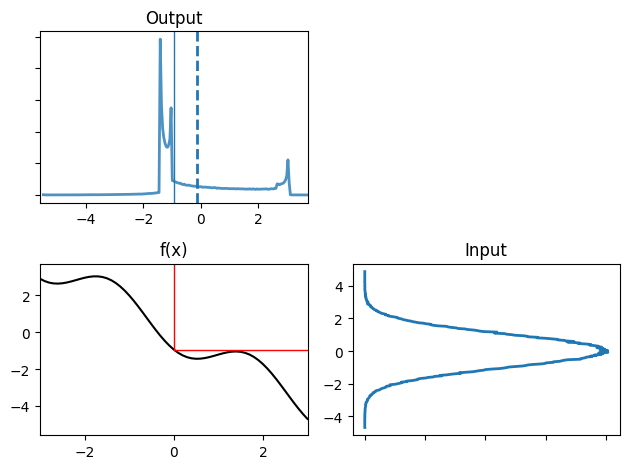

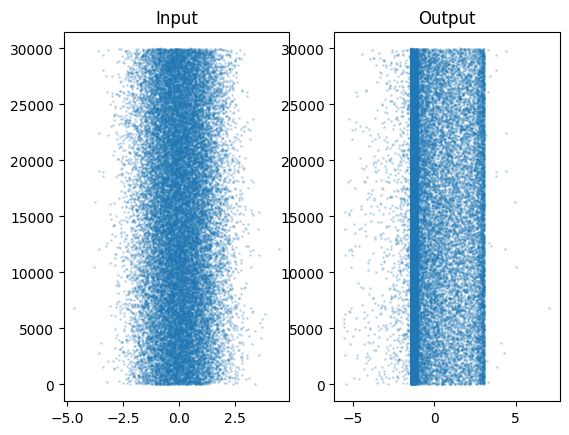

In [ ]:
gaussian = (0., 1.)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)

def f(x):
    return (np.cos(4*(x/2 + 0.7))) - 1.3*x

def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])

plot_nonlinear_func(data, f)

N = 30000
plt.subplot(121)
plt.scatter(data[:N], range(N), alpha=.2, s=1)
plt.title('Input')
plt.subplot(122)
plt.title('Output')
plt.scatter(f(data[:N]), range(N), alpha=.2, s=1)
plt.show()

Si inizializzano media e covarianza

In [ ]:
mean = (0., 0.)
p = np.array([[32., 15], [15., 40.]])

Si creano i punti sigma e i pesi

In [ ]:
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(mean, p)

Si passano attraverso la funzione non lineare

In [ ]:
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1])

Si utilizza la trasformazione unscented per ottenere la nuova media e covarianza 

In [ ]:
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)

Si generano punti casuali e, successivamente, si plottano

Difference in mean x=-0.097, y=0.549


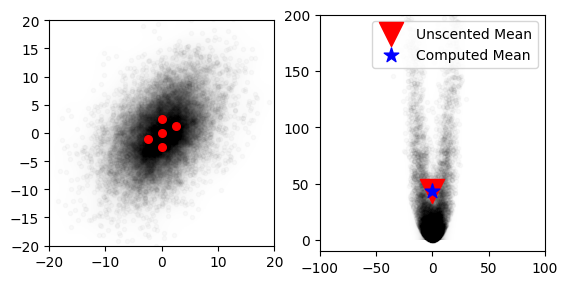

In [ ]:
np.random.seed(100)
xs, ys = multivariate_normal(mean=mean, cov=p, size=5000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, ukf_mean, 'Unscented Mean')
ax = plt.gcf().axes[0]
ax.scatter(sigmas[:,0], sigmas[:,1], c='r', s=30)
plt.show()

Mostriamo di seguito il codice completo

In [ ]:
from kf_book.book_plots import set_figsize, figsize
import matplotlib.pyplot as plt
from kf_book.nonlinear_plots import plot_nonlinear_func
from numpy.random import normal
import numpy as np
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats
from numpy.random import multivariate_normal
from kf_book.nonlinear_plots import plot_monte_carlo_mean



# creati 500,000 campioni con media 0, std 1
gaussian = (0., 1.)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)

def f(x):
    return (np.cos(4*(x/2 + 0.7))) - 1.3*x

def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])

plot_nonlinear_func(data, f)

N = 30000
plt.subplot(121)
plt.scatter(data[:N], range(N), alpha=.2, s=1)
plt.title('Input')
plt.subplot(122)
plt.title('Output')
plt.scatter(f(data[:N]), range(N), alpha=.2, s=1)
plt.show()


#inizializzo media e covarianza
mean = (0., 0.)
p = np.array([[32., 15], [15., 40.]])

# creo punti sigma e pesi 
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(mean, p)

# passo attraverso la funzione non lineare
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1])

# uso una trasformazione unscented per ottenere la nuova media e covarianza 
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)

# genero punti casuali 
np.random.seed(100)
xs, ys = multivariate_normal(mean=mean, cov=p, size=5000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, ukf_mean, 'Unscented Mean')
ax = plt.gcf().axes[0]
ax.scatter(sigmas[:,0], sigmas[:,1], c='r', s=30)
plt.show()